In [42]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [43]:
!pip install psycopg2-binary

In [61]:
import psycopg2 as pg

con = pg.connect("dbname=datawarehouse user=jarvis_ro password=XJk%72kV host=prod-dwh.cxmfelfcussu.ap-southeast-1.rds.amazonaws.com port=5432")
cur = con.cursor()

query = """
with order_value as (
select
	distinct id_order,
	order_date,
	(case
		when id_order_platform = 4 then 'offline'
		else 'in store pickup'
	end) platform_order,
	(case
		when id_order_platform = 4 then dos.store_alias
		else dos2.store_alias
	end) store_alias,
	(case
		when id_order_platform = 4 then dos.store_name
		else dos2.store_name
	end) store_name,
	dc.id_customer,
	dp.reference sku_ref,
	dp.product_name,
	dp.brand,
	dp.product_attribute,
	dp.category_default,
    -- before_discount,
	after_discount,
    (case when (1-(case when before_discount > 0 and after_discount > 0 then after_discount::float / before_discount::float else 1 end)) >= 0.60 and dp.brand != 'skin1004' then 1
		when dp.brand = 'skin1004' and dp.category_default = 'sheet mask' then 1
		else 0
		end
	) is_excluded,
    (1-(case when before_discount > 0 and after_discount > 0 then after_discount::float / before_discount::float else 1 end)) discount,
	(coalesce(after_discount /(foi.total_product_quantity - foi.refunded_quantity),0)) as price_per_unit,
	(foi.total_product_quantity - foi.refunded_quantity) qty
from
	dwh_revamp.fact_order_item foi
left join dwh_revamp.dim_customer dc on
	dc.id = foi.id_customer
left join dwh_revamp.dim_product dp on
	dp.id = foi.id_product
left join dwh_revamp.dim_offlinestore_store dos on
	foi.id_offlinestore_store = dos.id
left join dwh_revamp.dim_offlinestore_store dos2 on
	foi.fullfilment_offlinestore_id = dos2.id
where
	data_source = 'sociolla'
	and foi.sociolla_is_net = 1
	and foi.order_type != 'Egift'
	and foi.order_date::date between '2024-01-01' and '2024-05-31'
	and (id_order_platform = 4
		or order_type = 'In Store Pickup')
    and (dos.store_alias not in ('PE3','XTP','PSF','PE2'))
	and (foi.order_product_type = 'original'::enum_sociolla_order_product_type
		or ( foi.order_product_type = 'gift-with-purchase'::enum_sociolla_order_product_type
			and dp.product_classification = 'sellable_products'))
	and foi.after_discount > 0
	and foi.id_product not in (126938, 126942, 126940, 126936, 116486, 116489, 116485, 113660, 113711, 113661, 85154, 52611, 89814, 108440, 108442, 68508, 68689, 68722, 85160, 89810, 89813, 108437, 124954, 127938, 127934, 127929, 124955, 127886, 127885, 127930, 127933, 127937, 154732, 154730, 154731, 154729, 154727, 154728) ),
summary as (
select
	id_order,
	store_alias,
	store_name,
	after_discount,
	(case
		when price_per_unit <= 10000 then 'a. 0-10k'
		when price_per_unit > 10000
			and price_per_unit <= 50000 then 'b. >10-50k'
			when price_per_unit > 50000
			and price_per_unit <= 100000 then 'c. >50-100k'
			when price_per_unit > 100000
			and price_per_unit <= 300000 then 'd. >100-300k'
			when price_per_unit > 300000
			and price_per_unit <= 500000 then 'e. >300-500k'
			when price_per_unit > 500000
			and price_per_unit <= 1000000 then 'f. >500k-1mio'
			when price_per_unit > 1000000
			and price_per_unit <= 3000000 then 'g. >1-3mio'
			when price_per_unit > 3000000
			and price_per_unit <= 5000000 then 'h. >3-5mio'
			when price_per_unit > 5000000 then 'i. >5mio'
			else 'j. error'
		end) as price_range,
	qty
from
	order_value
-- where discount < 0.60 -- filtering discount 60 percent and up
where is_excluded = 0 -- filter discount 60 pct and up + skin1004 conditional
)
select
	distinct store_alias,
	store_name,
	price_range,
	sum(qty) as count_order
from
	summary
group by
	1,
	2,
	3
order by
	1,
	2,
	3
"""
cur.execute(query)


results = cur.fetchall()
# results = cur.fetchmany(10)


for row in results:
    print(row)

# Close cursor and connection
# cur.close()
# con.close()

('SAB', 'Sociolla Aeon BSD', 'a. 0-10k', Decimal('552'))
('SAB', 'Sociolla Aeon BSD', 'b. >10-50k', Decimal('37959'))
('SAB', 'Sociolla Aeon BSD', 'c. >50-100k', Decimal('37750'))
('SAB', 'Sociolla Aeon BSD', 'd. >100-300k', Decimal('45562'))
('SAB', 'Sociolla Aeon BSD', 'e. >300-500k', Decimal('3856'))
('SAB', 'Sociolla Aeon BSD', 'f. >500k-1mio', Decimal('283'))
('SAB', 'Sociolla Aeon BSD', 'g. >1-3mio', Decimal('10'))
('SAG', 'Sociolla AEON Jakarta Garden City', 'a. 0-10k', Decimal('68'))
('SAG', 'Sociolla AEON Jakarta Garden City', 'b. >10-50k', Decimal('14860'))
('SAG', 'Sociolla AEON Jakarta Garden City', 'c. >50-100k', Decimal('16681'))
('SAG', 'Sociolla AEON Jakarta Garden City', 'd. >100-300k', Decimal('18576'))
('SAG', 'Sociolla AEON Jakarta Garden City', 'e. >300-500k', Decimal('1255'))
('SAG', 'Sociolla AEON Jakarta Garden City', 'f. >500k-1mio', Decimal('102'))
('SAS', 'Sociolla Aeon Sentul', 'a. 0-10k', Decimal('137'))
('SAS', 'Sociolla Aeon Sentul', 'b. >10-50k', Decimal

In [62]:
df = pd.DataFrame(results, columns=['store_alias', 'store_name', 'price_range','count_order'])

df.head()

,store_alias,store_name,price_range,count_order
0,SAB,Sociolla Aeon BSD,a. 0-10k,552
1,SAB,Sociolla Aeon BSD,b. >10-50k,37959
2,SAB,Sociolla Aeon BSD,c. >50-100k,37750
3,SAB,Sociolla Aeon BSD,d. >100-300k,45562
4,SAB,Sociolla Aeon BSD,e. >300-500k,3856


In [63]:
df_drop = df.drop(columns=['store_name'])
df_drop.head()

,store_alias,price_range,count_order
0,SAB,a. 0-10k,552
1,SAB,b. >10-50k,37959
2,SAB,c. >50-100k,37750
3,SAB,d. >100-300k,45562
4,SAB,e. >300-500k,3856


In [64]:
pivot_df = df.pivot_table(index='store_alias', columns='price_range', values='count_order', fill_value=0)
# pivot_df.set_index('store_alias', inplace=True)
pivot_df.reset_index(inplace=True)

print(pivot_df)

price_range store_alias  a. 0-10k  b. >10-50k  c. >50-100k  d. >100-300k  \
0                   SAB     552.0     37959.0      37750.0       45562.0   
1                   SAG      68.0     14860.0      16681.0       18576.0   
2                   SAS     137.0     19064.0      22452.0       26399.0   
3                   SAY     231.0     25845.0      29136.0       30589.0   
4                   SBB     207.0     13938.0      11917.0       12844.0   
..                  ...       ...         ...          ...           ...   
65                  SSS     339.0     42996.0      45069.0       53700.0   
66                  STB     110.0     27276.0      30890.0       31453.0   
67                  STM     139.0     25535.0      27920.0       31867.0   
68                  STP     572.0     35506.0      36023.0       41436.0   
69                  STS     151.0     20710.0      25185.0       29514.0   

price_range  e. >300-500k  f. >500k-1mio  g. >1-3mio  
0                  3856.0       

In [65]:
pivot_df.set_index('store_alias', inplace=True)
print(pivot_df)

price_range  a. 0-10k  b. >10-50k  c. >50-100k  d. >100-300k  e. >300-500k  \
store_alias                                                                  
SAB             552.0     37959.0      37750.0       45562.0        3856.0   
SAG              68.0     14860.0      16681.0       18576.0        1255.0   
SAS             137.0     19064.0      22452.0       26399.0        2014.0   
SAY             231.0     25845.0      29136.0       30589.0        1643.0   
SBB             207.0     13938.0      11917.0       12844.0         649.0   
...               ...         ...          ...           ...           ...   
SSS             339.0     42996.0      45069.0       53700.0        3995.0   
STB             110.0     27276.0      30890.0       31453.0        1633.0   
STM             139.0     25535.0      27920.0       31867.0        2098.0   
STP             572.0     35506.0      36023.0       41436.0        2556.0   
STS             151.0     20710.0      25185.0       29514.0    

In [66]:
print(pivot_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, SAB to STS
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   a. 0-10k       70 non-null     float64
 1   b. >10-50k     70 non-null     float64
 2   c. >50-100k    70 non-null     float64
 3   d. >100-300k   70 non-null     float64
 4   e. >300-500k   70 non-null     float64
 5   f. >500k-1mio  70 non-null     float64
 6   g. >1-3mio     70 non-null     float64
dtypes: float64(7)
memory usage: 4.4+ KB
None


In [67]:
# row-wise normalization to count distribution
df_normalized = pivot_df.div(pivot_df.sum(axis=1),axis=0)
df_normalized.reset_index(inplace = True)
print(df_normalized)

price_range store_alias  a. 0-10k  b. >10-50k  c. >50-100k  d. >100-300k  \
0                   SAB  0.004382    0.301329     0.299670      0.361684   
1                   SAG  0.001319    0.288309     0.323639      0.360405   
2                   SAS  0.001950    0.271389     0.319620      0.375808   
3                   SAY  0.002639    0.295263     0.332861      0.349461   
4                   SBB  0.005230    0.352139     0.301079      0.324499   
..                  ...       ...         ...          ...           ...   
65                  SSS  0.002313    0.293424     0.307571      0.366473   
66                  STB  0.001203    0.298271     0.337791      0.343948   
67                  STM  0.001585    0.291117     0.318307      0.363306   
68                  STP  0.004917    0.305200     0.309644      0.356172   
69                  STS  0.001935    0.265384     0.322727      0.378200   

price_range  e. >300-500k  f. >500k-1mio  g. >1-3mio  
0                0.030610       

In [68]:
df_normalized.set_index('store_alias', inplace=True)
print(df_normalized)

price_range  a. 0-10k  b. >10-50k  c. >50-100k  d. >100-300k  e. >300-500k  \
store_alias                                                                  
SAB          0.004382    0.301329     0.299670      0.361684      0.030610   
SAG          0.001319    0.288309     0.323639      0.360405      0.024349   
SAS          0.001950    0.271389     0.319620      0.375808      0.028671   
SAY          0.002639    0.295263     0.332861      0.349461      0.018770   
SBB          0.005230    0.352139     0.301079      0.324499      0.016397   
...               ...         ...          ...           ...           ...   
SSS          0.002313    0.293424     0.307571      0.366473      0.027264   
STB          0.001203    0.298271     0.337791      0.343948      0.017857   
STM          0.001585    0.291117     0.318307      0.363306      0.023919   
STP          0.004917    0.305200     0.309644      0.356172      0.021971   
STS          0.001935    0.265384     0.322727      0.378200    

C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


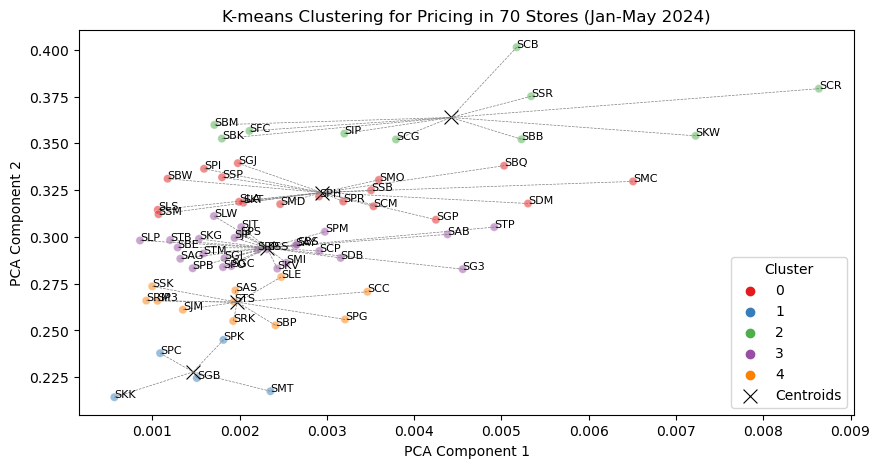

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

numerical_columns = df_normalized.select_dtypes(include=['float64']).columns


X = df_normalized[numerical_columns]
n_clusters = 5


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
centroids = kmeans.cluster_centers_

cluster_labels = kmeans.labels_

df_normalized['cluster'] = cluster_labels

def plot_clusters_with_centroids(X, cluster_labels, centroids, store_alias, title):
    # Plot clusters with centroids
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels, palette='Set1', legend='full', alpha=0.5)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

    # Connect data points to centroids with lines
    for i in range(len(X)):
        plt.plot([X[i, 0], centroids[cluster_labels[i], 0]], [X[i, 1], centroids[cluster_labels[i], 1]], color='gray', linestyle='--', linewidth=0.5)
        plt.text(X[i, 0], X[i, 1], store_alias[i], fontsize=8)  # Display store_alias for each data point

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Plot K-means clusters with centroids and lines
plot_clusters_with_centroids(X.values, cluster_labels, centroids, df_normalized.index, 'K-means Clustering for Pricing in 70 Stores (Jan-May 2024)')


In [70]:
print(df_normalized)

price_range  a. 0-10k  b. >10-50k  c. >50-100k  d. >100-300k  e. >300-500k  \
store_alias                                                                  
SAB          0.004382    0.301329     0.299670      0.361684      0.030610   
SAG          0.001319    0.288309     0.323639      0.360405      0.024349   
SAS          0.001950    0.271389     0.319620      0.375808      0.028671   
SAY          0.002639    0.295263     0.332861      0.349461      0.018770   
SBB          0.005230    0.352139     0.301079      0.324499      0.016397   
...               ...         ...          ...           ...           ...   
SSS          0.002313    0.293424     0.307571      0.366473      0.027264   
STB          0.001203    0.298271     0.337791      0.343948      0.017857   
STM          0.001585    0.291117     0.318307      0.363306      0.023919   
STP          0.004917    0.305200     0.309644      0.356172      0.021971   
STS          0.001935    0.265384     0.322727      0.378200    

In [71]:
print(X)

price_range  a. 0-10k  b. >10-50k  c. >50-100k  d. >100-300k  e. >300-500k  \
store_alias                                                                  
SAB          0.004382    0.301329     0.299670      0.361684      0.030610   
SAG          0.001319    0.288309     0.323639      0.360405      0.024349   
SAS          0.001950    0.271389     0.319620      0.375808      0.028671   
SAY          0.002639    0.295263     0.332861      0.349461      0.018770   
SBB          0.005230    0.352139     0.301079      0.324499      0.016397   
...               ...         ...          ...           ...           ...   
SSS          0.002313    0.293424     0.307571      0.366473      0.027264   
STB          0.001203    0.298271     0.337791      0.343948      0.017857   
STM          0.001585    0.291117     0.318307      0.363306      0.023919   
STP          0.004917    0.305200     0.309644      0.356172      0.021971   
STS          0.001935    0.265384     0.322727      0.378200    

In [72]:
from sklearn.decomposition import PCA as pca

df_for_pca = df_normalized.drop(columns=['cluster'])

pca = PCA(n_components=2)  # Number of components can be adjusted
pca.fit(df_for_pca)

def get_pca_component_scores(df_for_pca, pca):
    explained_variance_ratio = pca.explained_variance_ratio_

    abs_components = np.abs(pca.components_)


    component_scores = pd.DataFrame(abs_components.T, columns=[f'PC{i+1}' for i in range(len(explained_variance_ratio))])
    component_scores['Attribute'] = df_for_pca.columns
    component_scores = component_scores.set_index('Attribute').apply(lambda x: x / x.sum(), axis=0)  # Normalize scores
    component_scores = component_scores.sort_values(by=['PC1', 'PC2'], ascending=False)  # Sort by influence on PC1 and PC2
    return component_scores

pca_component_scores = get_pca_component_scores(df_for_pca, pca)

print("PCA Component Scores:")
print(pca_component_scores)


PCA Component Scores:
                    PC1       PC2
Attribute                        
b. >10-50k     0.489154  0.151001
d. >100-300k   0.415057  0.200623
e. >300-500k   0.047806  0.124731
c. >50-100k    0.030822  0.500000
a. 0-10k       0.010846  0.006104
f. >500k-1mio  0.006306  0.017000
g. >1-3mio     0.000009  0.000541


In [75]:
with pd.ExcelWriter('20240628 - version 3 new price clustering pivot and pca.xlsx') as writer:
    df_normalized.to_excel(writer, sheet_name='df_normalized', index=True)
    pca_component_scores.to_excel(writer, sheet_name='pca_component_scores')
    pivot_df.to_excel(writer, sheet_name='raw_data')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

centroids = kmeans.cluster_centers_

X = pivot_df
def plot_clusters_with_centroids(X, cluster_labels, centroids, store_alias, title):
    # Plot clusters with centroids
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels, palette='Set1', legend='full', alpha=0.5)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

# Connect data points to centroids with lines
    for i in range(len(X)):
        plt.plot([X[i, 0], centroids[cluster_labels[i], 0]], [X[i, 1], centroids[cluster_labels[i], 1]], color='gray', linestyle='--', linewidth=0.5)
        plt.text(X[i, 0], X[i, 1], store_alias[i], fontsize=8)  # Display store_alias for each data point

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Plot K-means clusters with centroids and lines
plot_clusters_with_centroids(X, cluster_labels, centroids, pivot_df.index, 'K-means Clustering with Centroids and Store Alias')





# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# centroids = kmeans.cluster_centers_



# def plot_clusters_with_centroids(X, cluster_labels, title):
#     # Fit KMeans to get cluster centroids
#     kmeans = KMeans(n_clusters=len(set(cluster_labels)), random_state=42)
#     kmeans.fit(X)
#     centroids = kmeans.cluster_centers_

#     # Plot clusters with centroids
#     plt.figure(figsize=(10, 5))
#     sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels, palette='Set1', legend='full', alpha=0.5)
#     sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
#     plt.title(title)
#     plt.xlabel('PCA Component 1')
#     plt.ylabel('PCA Component 2')
#     plt.legend(title='Cluster')

#     # Connect data points to centroids with lines
#     for i in range(len(X)):
#         plt.plot([X[i, 0], centroids[cluster_labels[i], 0]], [X[i, 1], centroids[cluster_labels[i], 1]], color='gray', linestyle='--', linewidth=0.5)
#     plt.show()
    
    


# # Plot K-means clusters with centroids and lines

# plot_clusters_with_centroids(X_pca, df['kmeans_cluster'], 'K-means Clustering (PCA Viz)')

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1000x500 with 0 Axes>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# drop everything aside from id_order as key and category_default as attribute -- unsure about qty
df_cluster = df.drop(columns=["order_date", "platform_order", "store_alias", "store_name", "id_customer", "sku_ref", "product_name", "brand", "product_attribute", "before_discount", "after_discount","qty"])

one_hot_encoded = pd.get_dummies(df_cluster['category_default'], prefix='category')
df_cluster_encoded = pd.concat([df_cluster, one_hot_encoded], axis=1)
df_cluster_encoded.drop(columns=['category_default'], inplace=True)

df_cluster_encoded.head(20)

,id_order,category_2in1 body wash/head-to-toe wash,category_acne / pimple patch,category_acne treatment / sealing gel / cream,category_after sun care,category_ampoule,category_baby wipes,category_bath & body set,category_bb & cc cream,category_beauty suplements,...,category_sponge & applicators,category_sunscreen,category_supplement,category_toner,category_tooth whitening,category_touch-ups sunscreen,category_toys & surface cleaner,category_travel bottles & makeup case,category_treatment,category_wash off mask
0,6443ae0431c5b70a8b5c687c,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6458ecd09f0a5ebf88299680,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,644a6df19f47abe73e2f3731,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,64c38ffbe1b467204ca12a60,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6443ae573ccdec7203fcc63b,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,644a7524f1c12f5a46f8b513,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,64424d7ac304753deed03401,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,644cd83d03975e5e80a23e1c,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
8,645643100e82db174962a49e,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
9,644f3e1ed409803afde4035a,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
X = df_cluster_encoded.drop(columns=['id_order'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


k = 5  # Number of neighbors
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)


clusters = kmeans.labels_
df_cluster_encoded['cluster'] = clusters

C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# print(df_cluster_encoded[['id_order', 'cluster']].head(10))
print(df_cluster_encoded.head(30))

                    id_order  category_2in1 body wash/head-to-toe wash  \
0   6443ae0431c5b70a8b5c687c                                     False   
1   6458ecd09f0a5ebf88299680                                     False   
2   644a6df19f47abe73e2f3731                                     False   
3   64c38ffbe1b467204ca12a60                                     False   
4   6443ae573ccdec7203fcc63b                                     False   
5   644a7524f1c12f5a46f8b513                                     False   
6   64424d7ac304753deed03401                                     False   
7   644cd83d03975e5e80a23e1c                                     False   
8   645643100e82db174962a49e                                     False   
9   644f3e1ed409803afde4035a                                     False   
10  64411dafb14b7524876c70c0                                     False   
11  643f7733105274bf2b9106bb                                     False   
12  644a6f81421bdf4afa5a8592          

In [ ]:
#df_cluster_encoded.to_csv('cluster_encoded_full.csv', index=False)

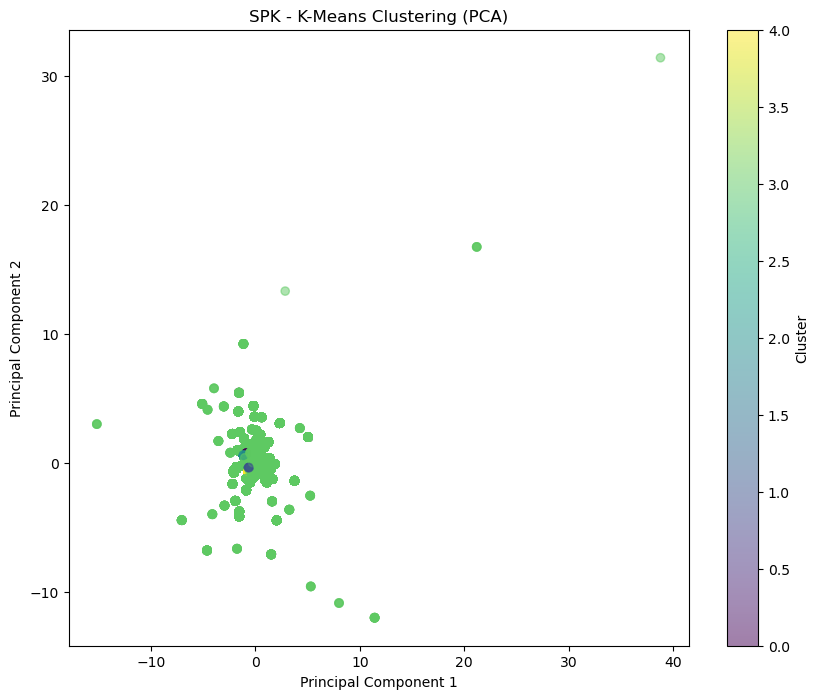

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality using PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

centroids = kmeans.cluster_centers_



# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)

# plt.figure(figsize=(10, 8))
# for i, centroid in enumerate(centroids):
#     cluster_points = X_pca[clusters == i]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=f'C{i}', alpha=0.5, label=f'Cluster {i}')    
#     plt.scatter(centroid[0], centroid[1], marker='X', s=200, color='red')
#     for point in cluster_points:
#         plt.plot([centroid[0], point[0]], [centroid[1], point[1]], c=f'C{i}', alpha=0.3)



plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SPK - K-Means Clustering (PCA)')
plt.colorbar(label='Cluster')
plt.show()

## Trying association rule mining algorithm: FP-Growth & Apriori

In [ ]:
df_for_arm = df.drop(columns=["order_date", "platform_order", "store_alias", "store_name", "id_customer", "sku_ref", "product_name", "brand", "product_attribute", "before_discount", "after_discount"])


df_for_arm.tail()

,id_order,category_default,qty
97568,64854a22189e34e166053bdd,toner,1
97569,64db8512e954f20c7862bf13,toner,1
97570,64bb5c281742f5df144470c1,toner,1
97571,64e86a24fca4bcd7d21b7c2b,toner,1
97572,64bce99a008a728a463342e2,toner,1


In [ ]:
def expand_rows(row):
    if row['qty'] > 1:
        return pd.DataFrame([row] * row['qty'], index=range(row['qty']))
    else:
        return pd.DataFrame([row])
    
expanded_df = pd.concat(df_for_arm.apply(expand_rows, axis=1).values)
expanded_df.reset_index(drop=True, inplace=True)
expanded_df.head(10)

,id_order,category_default,qty
0,6443ae0431c5b70a8b5c687c,face serum,1
1,6458ecd09f0a5ebf88299680,toner,1
2,644a6df19f47abe73e2f3731,sunscreen,1
3,64c38ffbe1b467204ca12a60,face serum,1
4,6443ae573ccdec7203fcc63b,acne treatment / sealing gel / cream,1
5,644a7524f1c12f5a46f8b513,mascara,1
6,64424d7ac304753deed03401,face wash,1
7,644cd83d03975e5e80a23e1c,sunscreen,1
8,645643100e82db174962a49e,sunscreen,1
9,644f3e1ed409803afde4035a,sunscreen,1


In [ ]:
!pip install mlxtend

In [ ]:
#fpgrowth

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pandas as pd

fpgrowth_df = expanded_df.drop(columns=['qty'])
fpgrowth_df.dropna(inplace=True)


transaction_list = fpgrowth_df.groupby('id_order')['category_default'].apply(list).values.tolist()
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
df_binary = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df_binary, min_support=0.01, use_colnames=True)
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# print(frequent_itemsets)

print(frequent_itemsets_sorted)


     support                               itemsets
5   0.155154                           (sheet mask)
2   0.141604                            (sunscreen)
14  0.106025                             (lip tint)
20  0.100169                           (face serum)
25  0.087599                                (toner)
..       ...                                    ...
56  0.010904                  (lip tint, sunscreen)
59  0.010855                     (face wash, toner)
26  0.010708                            (face mist)
50  0.010389  (body lotion / body serum, sunscreen)
40  0.010022              (body scrub & exfoliants)

[65 rows x 2 columns]


In [ ]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets_apriori = apriori(df_binary, min_support=0.01, use_colnames=True)
print(frequent_itemsets_apriori)


     support                                itemsets
0   0.083066                   (acne / pimple patch)
1   0.021906  (acne treatment / sealing gel / cream)
2   0.016001                               (ampoule)
3   0.027542                                 (blush)
4   0.063316              (body lotion / body serum)
..       ...                                     ...
60  0.012619                  (lip tint, sheet mask)
61  0.010904                   (lip tint, sunscreen)
62  0.018059                 (sheet mask, sunscreen)
63  0.012962                     (sheet mask, toner)
64  0.014996                      (toner, sunscreen)

[65 rows x 2 columns]


In [ ]:
frequent_itemsets_apriori_sorted = frequent_itemsets_apriori.sort_values(by='support', ascending=False)
print(frequent_itemsets_apriori_sorted)

     support                               itemsets
42  0.155154                           (sheet mask)
44  0.141604                            (sunscreen)
34  0.106025                             (lip tint)
27  0.100169                           (face serum)
45  0.087599                                (toner)
..       ...                                    ...
61  0.010904                  (lip tint, sunscreen)
59  0.010855                     (face wash, toner)
24  0.010708                            (face mist)
47  0.010389  (body lotion / body serum, sunscreen)
5   0.010022              (body scrub & exfoliants)

[65 rows x 2 columns]


In [ ]:
#download results to csv
#please change the name according to store

file_path = 'spk_association_results.xlsx'

with pd.ExcelWriter(file_path) as writer:
    frequent_itemsets.to_excel(writer, sheet_name='fpgrowth', index=False)
    frequent_itemsets_apriori.to_excel(writer, sheet_name='apriori', index=False)

###Visualization

In [ ]:
!pip install networkx

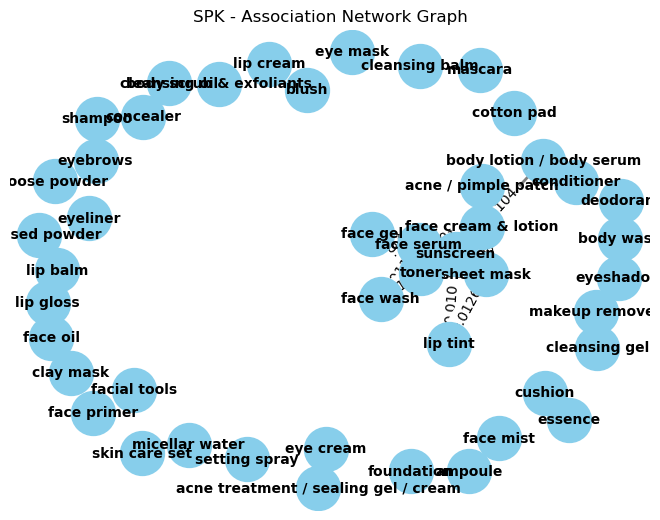

In [ ]:
import networkx as nx

G = nx.Graph()

for idx, row in frequent_itemsets.iterrows():
    for item in row['itemsets']:
        G.add_node(item)


for idx, row in frequent_itemsets.iterrows():
    items = list(row['itemsets'])  # Convert frozenset to list
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                G.add_edge(items[i], items[j], weight=row['support'])



pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)


edge_labels = {(u, v): round(d['weight'], 4) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


plt.title('SPK - Association Network Graph')
plt.show()

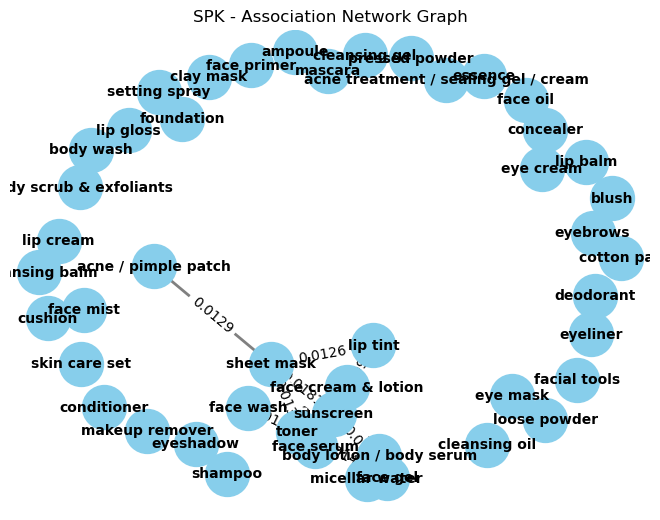

In [ ]:
#apriori
import networkx as nx

G = nx.Graph()

for idx, row in frequent_itemsets_apriori.iterrows():
    for item in row['itemsets']:
        G.add_node(item)


for idx, row in frequent_itemsets_apriori.iterrows():
    items = list(row['itemsets'])  # Convert frozenset to list
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                G.add_edge(items[i], items[j], weight=row['support'])



pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)


edge_labels = {(u, v): round(d['weight'], 4) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


plt.title('SPK - Association Network Graph')
plt.show()

In [ ]:
## stop here

C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_20600\1804718210.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.011172720632180092' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  itemsets_matrix.loc[items[i], items[j]] = row['support']
C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_20600\1804718210.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.011172720632180092' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  itemsets_matrix.loc[items[j], items[i]] = row['support']
C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_20600\1804718210.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.011064811740487417' has dtype incompatible with int64, please explicitly cast to

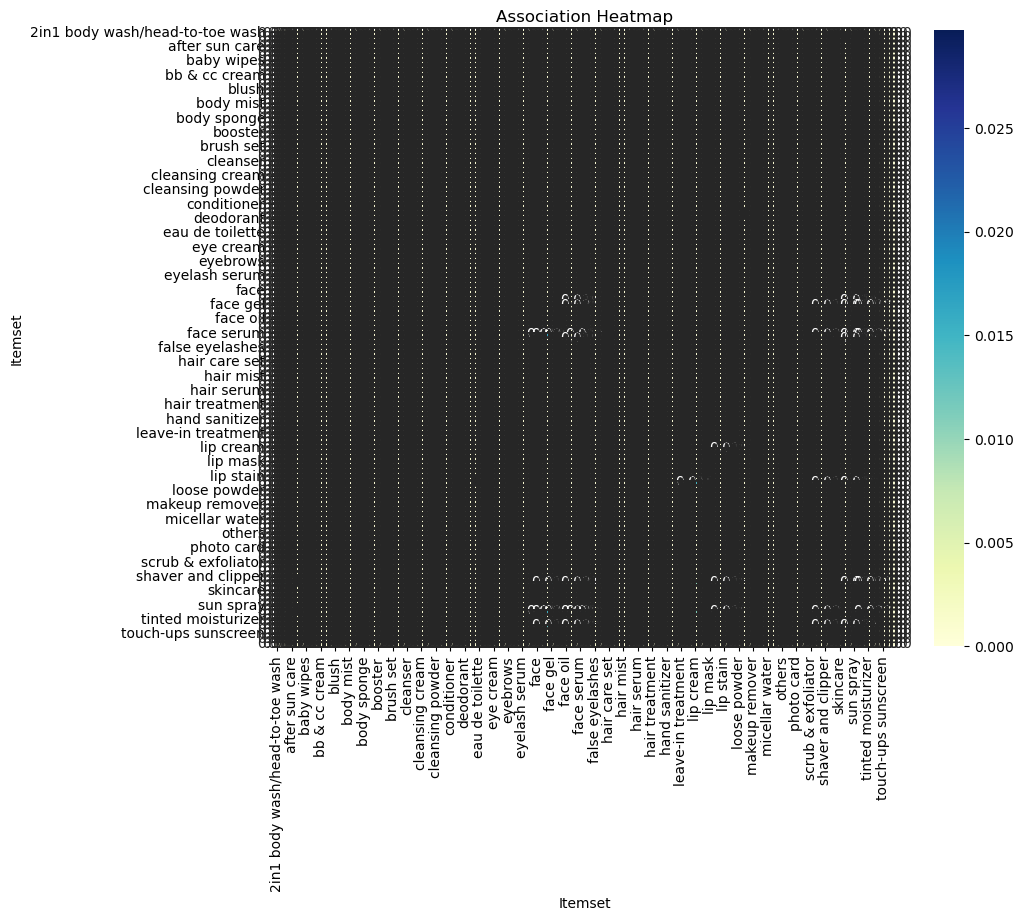

In [ ]:
import seaborn as sns

itemsets_matrix = pd.DataFrame(index=te.columns_, columns=te.columns_)
itemsets_matrix.fillna(0, inplace=True)


for idx, row in frequent_itemsets_apriori.iterrows():
    items = list(row['itemsets'])
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                itemsets_matrix.loc[items[i], items[j]] = row['support']
                itemsets_matrix.loc[items[j], items[i]] = row['support']


plt.figure(figsize=(10, 8))
sns.heatmap(itemsets_matrix, cmap="YlGnBu", annot=True, fmt=".3f")
plt.title('Association Heatmap')
plt.xlabel('Itemset')
plt.ylabel('Itemset')
plt.show()

In [ ]:
# T-distributed Stochastic Neighbor Embedding (t-SNE)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality using t-SNE to 2 components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-Means Clustering (t-SNE)')
plt.colorbar(label='Cluster')
plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score

2. Initial Clustering on Variable Categories

Drop the store_name column to extract only the features in the dataset.

In [ ]:
df_group1_features = df_group1.drop(columns=['store_name'])
df_group2_features = df_group2.drop(columns=['store_name'])
df_group3_features = df_group3.drop(columns=['store_name'])
df_group4_features = df_group4.drop(columns=['store_name'])
df_group5_features = df_group5.drop(columns=['store_name'])


In [ ]:
#test content
df_group4_features.head()

,store_size,sales_per_sqm,store_life,area_category,city_type
0,425,5.373547e+06,12,a. Jabodetabek,Kota
1,377,6.760138e+06,12,b. Java exc Jabodetabek,Kota
2,317,6.977097e+06,12,a. Jabodetabek,Kabupaten
3,307,5.175276e+06,12,a. Jabodetabek,Kota
4,272,9.661400e+06,12,c. Outside Java,Kota


Categorical columns only exist in group 4 (area_category, city_type). Hence, we do encoding to scale those values to 0 - 1. For the rest of the numeric columns, we use a scaler function to normalize the values.

3. Standardization/Normalization Data Pre-Processing - because K-means is VERY sensitive to the scale of features

In [ ]:
# scaling for all groups with numerical features only
scaler = StandardScaler()
df_group1_features_scaled = scaler.fit_transform(df_group1_features)
df_group2_features_scaled = scaler.fit_transform(df_group2_features) # not sure if aov needs scaling but let's try both
df_group3_features_scaled = scaler.fit_transform(df_group3_features)
df_group5_features_scaled = scaler.fit_transform(df_group5_features)


In [ ]:
# change this part to test
original_dataset = df_group3_features
check_dataset = df_group3_features_scaled

check_dataset = pd.DataFrame(check_dataset, columns=original_dataset.columns)
check_dataset.head()

,cat_skincare,cat_makeup,cat_bath_and_body,cat_haircare,cat_accessories,cat_fragrance,brand_mass,brand_premium_mass,brand_premium,brand_luxe
0,0.672182,-0.883233,-1.090151,1.183681,1.342557,-0.068125,-0.432970,-1.465869,1.522720,3.382039
1,0.389101,-0.996746,0.036216,2.300342,1.662814,-0.408877,-0.107125,-1.228935,1.148001,1.761799
2,-0.422588,0.099458,-0.273225,0.766615,0.641996,-0.200253,-0.123216,-0.775972,0.803941,0.764729
3,-0.988748,0.281078,-0.087560,0.833883,1.923023,0.064004,-1.136957,-0.964126,1.662387,2.925048
4,0.753062,-1.243229,0.679854,0.726253,0.902205,-0.339336,0.500315,-0.173184,-0.299775,0.557005


In [ ]:
# scaling and encoding for df_group4_features which has both numerical and categorical columns

# Define the column names
categorical_columns = ['area_category', 'city_type']
numerical_columns = ['store_size', 'sales_per_sqm', 'store_life']

# Create transformers for numerical and categorical columns
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform the data
df_group4_features_scaled = preprocessor.fit_transform(df_group4_features)

# Get the column names after transformation
numerical_columns_list = numerical_columns
categorical_columns_list = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Combine numerical and categorical column names
columns = numerical_columns_list + list(categorical_columns_list)

# Create a DataFrame with the scaled features
df_group4_features_scaled = pd.DataFrame(df_group4_features_scaled, columns=columns)

# Print the first few rows of the transformed 
print(df_group4_features_scaled.head())

   store_size  sales_per_sqm  store_life  area_category_a. Jabodetabek  \
0    3.394702      -0.880069    0.378968                           1.0   
1    2.767004      -0.511270    0.378968                           0.0   
2    1.982382      -0.453565    0.378968                           1.0   
3    1.851612      -0.932804    0.378968                           1.0   
4    1.393915       0.260393    0.378968                           0.0   

   area_category_b. Java exc Jabodetabek  area_category_c. Outside Java  \
0                                    0.0                            0.0   
1                                    1.0                            0.0   
2                                    0.0                            0.0   
3                                    0.0                            0.0   
4                                    0.0                            1.0   

   city_type_Kabupaten  city_type_Kota  
0                  0.0             1.0  
1                  0.0

In [ ]:
# convert result back to dataframe to test

columns = list(numerical_columns) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns))
# columns = list(numerical_columns) + list(categorical_columns)
df_group4_features_scaled_check = pd.DataFrame(df_group4_features_scaled, columns=columns)
print(df_group4_features_scaled_check.head())

   store_size  sales_per_sqm  store_life  area_category_a. Jabodetabek  \
0    3.394702      -0.880069    0.378968                           1.0   
1    2.767004      -0.511270    0.378968                           0.0   
2    1.982382      -0.453565    0.378968                           1.0   
3    1.851612      -0.932804    0.378968                           1.0   
4    1.393915       0.260393    0.378968                           0.0   

   area_category_b. Java exc Jabodetabek  area_category_c. Outside Java  \
0                                    0.0                            0.0   
1                                    1.0                            0.0   
2                                    0.0                            0.0   
3                                    0.0                            0.0   
4                                    0.0                            1.0   

   city_type_Kabupaten  city_type_Kota  
0                  0.0             1.0  
1                  0.0

In [ ]:
# Print the number of columns and rows
num_rows, num_columns = df_group4_features_scaled_check.shape
print(f"Number of columns: {num_columns}")
print(f"Number of rows: {num_rows}")

# Print the DataFrame to check the first few rows
print(df_group4_features_scaled_check.head())

columns_list = df_group4_features_scaled_check.columns.tolist()
print("Column names:")
print(columns_list)


Number of columns: 8
Number of rows: 54
   store_size  sales_per_sqm  store_life  area_category_a. Jabodetabek  \
0    3.394702      -0.880069    0.378968                           1.0   
1    2.767004      -0.511270    0.378968                           0.0   
2    1.982382      -0.453565    0.378968                           1.0   
3    1.851612      -0.932804    0.378968                           1.0   
4    1.393915       0.260393    0.378968                           0.0   

   area_category_b. Java exc Jabodetabek  area_category_c. Outside Java  \
0                                    0.0                            0.0   
1                                    1.0                            0.0   
2                                    0.0                            0.0   
3                                    0.0                            0.0   
4                                    0.0                            1.0   

   city_type_Kabupaten  city_type_Kota  
0                  0.0 

4. Running k-means algorithm with k=5 or k=6 on each of the mini clusters using loop function

In [ ]:
num_clusters = 5 # or 6

#-----------
# GROUP 1
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group1_features_scaled, pd.DataFrame):
    df_group1_features_scaled = pd.DataFrame(df_group1_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group1_features_scaled)

df_group1_clustered = df_group1_features_scaled.copy()
df_group1_clustered['Cluster'] = clusters


#-----------
# GROUP 2
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group2_features_scaled, pd.DataFrame):
    df_group2_features_scaled = pd.DataFrame(df_group2_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group2_features_scaled)

df_group2_clustered = df_group2_features_scaled.copy()
df_group2_clustered['Cluster'] = clusters

#-----------
# GROUP 3
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group3_features_scaled, pd.DataFrame):
    df_group3_features_scaled = pd.DataFrame(df_group3_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group3_features_scaled)

df_group3_clustered = df_group3_features_scaled.copy()
df_group3_clustered['Cluster'] = clusters


#-----------
# GROUP 4
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group4_features_scaled, pd.DataFrame):
    df_group4_features_scaled = pd.DataFrame(df_group4_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group4_features_scaled)

df_group4_clustered = df_group4_features_scaled.copy()
df_group4_clustered['Cluster'] = clusters

#-----------
# GROUP 5
#-----------

# convert from numPy to dataframe to append new column
if not isinstance(df_group5_features_scaled, pd.DataFrame):
    df_group5_features_scaled = pd.DataFrame(df_group5_features_scaled)
    
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_group5_features_scaled)

df_group5_clustered = df_group5_features_scaled.copy()
df_group5_clustered['Cluster'] = clusters


C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tiara.santoso\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436

5. PCA centroid plotting to show the distribution of the datapoints for each mini-cluster 

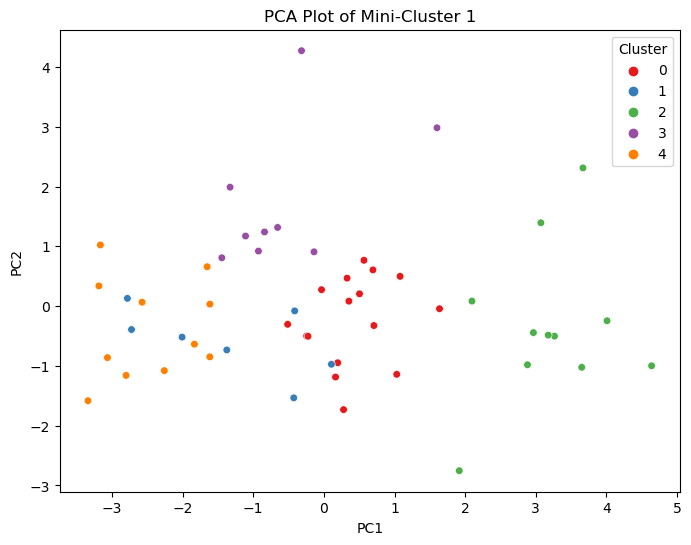

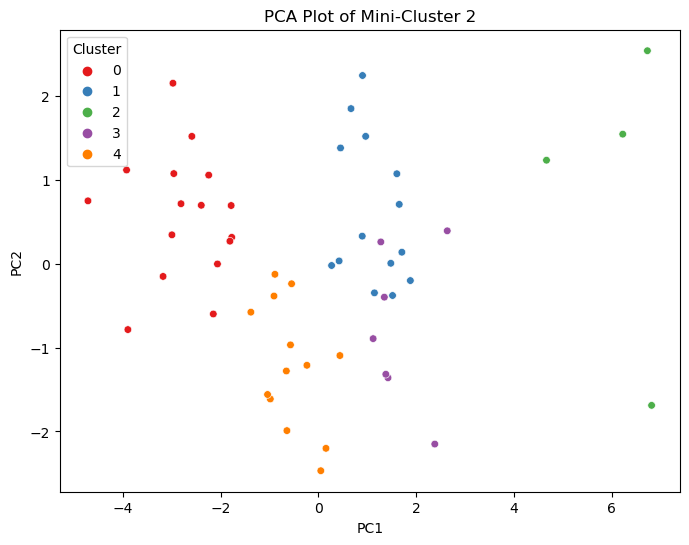

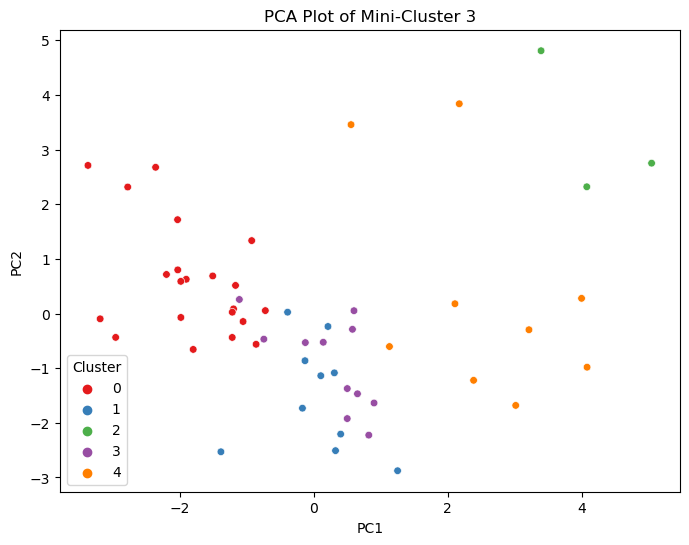

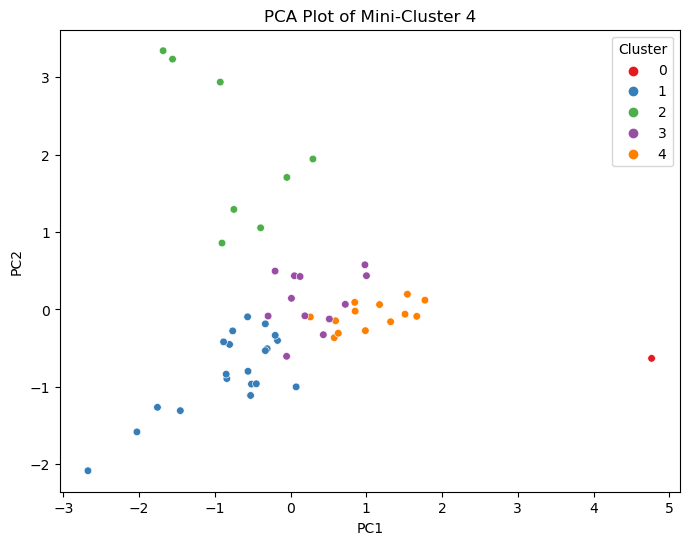

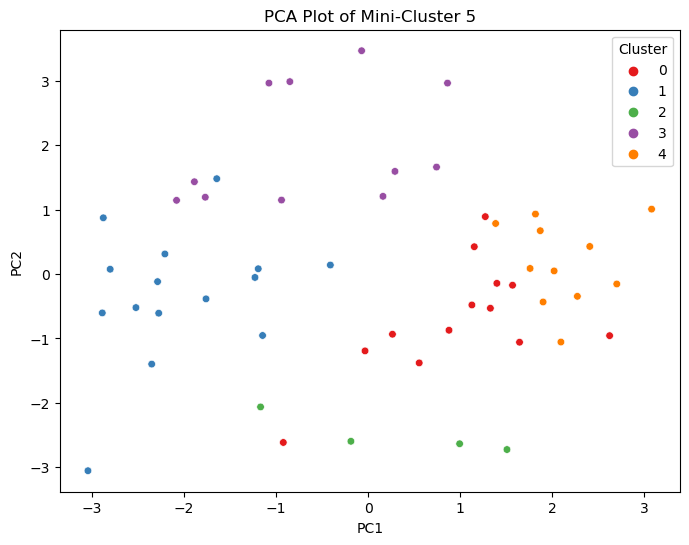

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# List of mini-cluster dataframes
mini_clusters = [df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered]

# Define a custom color palette for clusters
custom_palette = sns.color_palette("Set1", n_colors=len(mini_clusters))

# Apply PCA and plot for each mini-cluster
for i, mini_cluster in enumerate(mini_clusters, 1):
    # Extract the feature columns (excluding 'Cluster' column)
    feature_columns = mini_cluster.columns.difference(['Cluster'])

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(mini_cluster[feature_columns])

    # Create a new dataframe with PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = mini_cluster['Cluster']

    # Plot the PCA results for each mini-cluster with custom size and color palette
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30)
    plt.title(f'PCA Plot of Mini-Cluster {i}')
    plt.show()

C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_2852\1819321214.py:38: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points


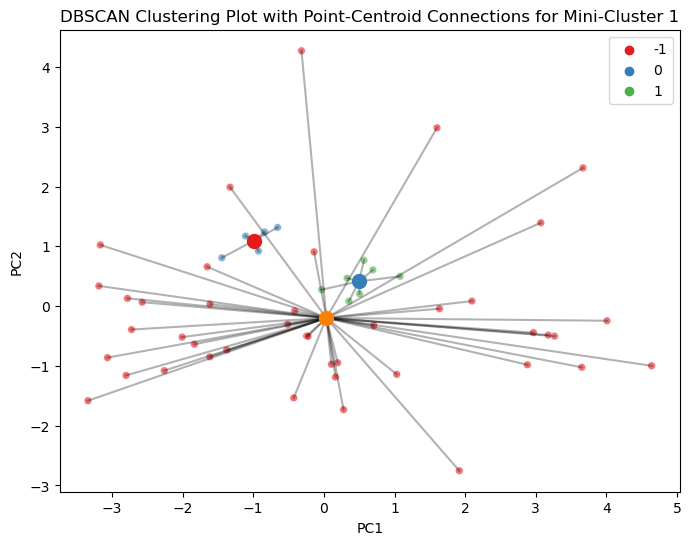

C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_2852\1819321214.py:38: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points


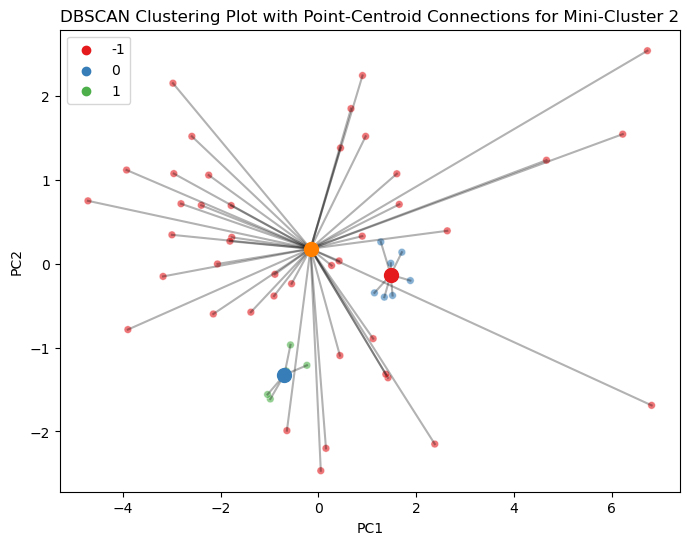

C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_2852\1819321214.py:38: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points


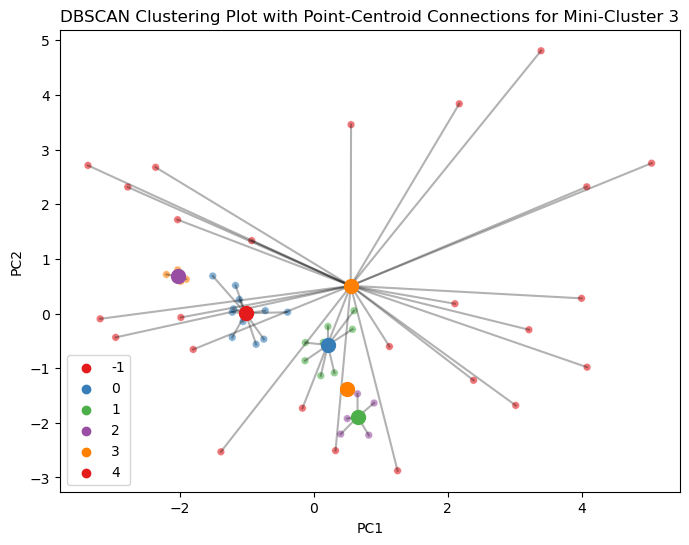

C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_2852\1819321214.py:38: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points


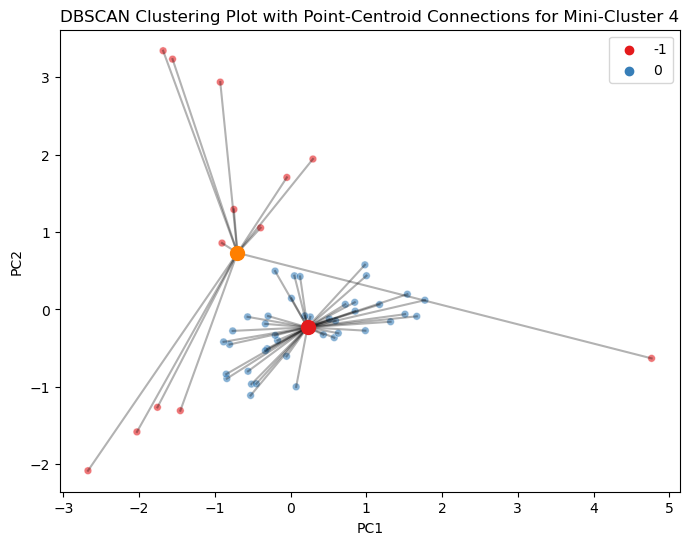

C:\Users\tiara.santoso\AppData\Local\Temp\ipykernel_2852\1819321214.py:38: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points


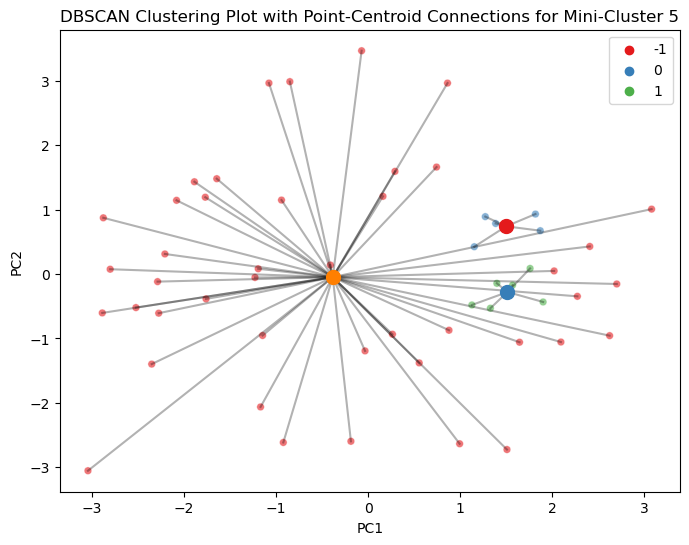

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
# import seaborn as sns
# import matplotlib.pyplot as plt

# # List of mini-cluster dataframes
# mini_clusters = [df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered]
# # Define a custom color palette for clusters using 'Set1'
# custom_palette = sns.color_palette("Set1", n_colors=len(mini_clusters))

# # Apply DBSCAN and plot for each mini-cluster
# for i, mini_cluster in enumerate(mini_clusters, 1):
#     # Extract the feature columns (excluding 'Cluster' column)
#     feature_columns = mini_cluster.columns.difference(['Cluster'])

#     # Apply PCA
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(mini_cluster[feature_columns])

#     # Apply DBSCAN
#     dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples
#     labels = dbscan.fit_predict(pca_result)

#     # Create a new dataframe with PCA results and cluster labels
#     df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     df_pca['Cluster'] = labels

#     # Calculate centroids
#     centroids = df_pca.groupby('Cluster').mean()

#     # Plot the DBSCAN clustering results for each mini-cluster with custom size and color palette
#     plt.figure(figsize=(8, 6))
#     for cluster, centroid in centroids.iterrows():
#         points_in_cluster = df_pca[df_pca['Cluster'] == cluster][['PC1', 'PC2']].values
#         for point in points_in_cluster:
#             plt.plot([point[0], centroid['PC1']], [point[1], centroid['PC2']], 'k-', alpha=0.3)  # Lines from points to centroid
#         plt.plot(centroid['PC1'], centroid['PC2'], 'o', color=custom_palette[cluster], markersize=10)  # Plot centroid
#     sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30, alpha=0.6)  # Plot points
#     plt.title(f'DBSCAN Clustering Plot with Point-Centroid Connections for Mini-Cluster {i}')
#     plt.legend()
#     plt.show()

    

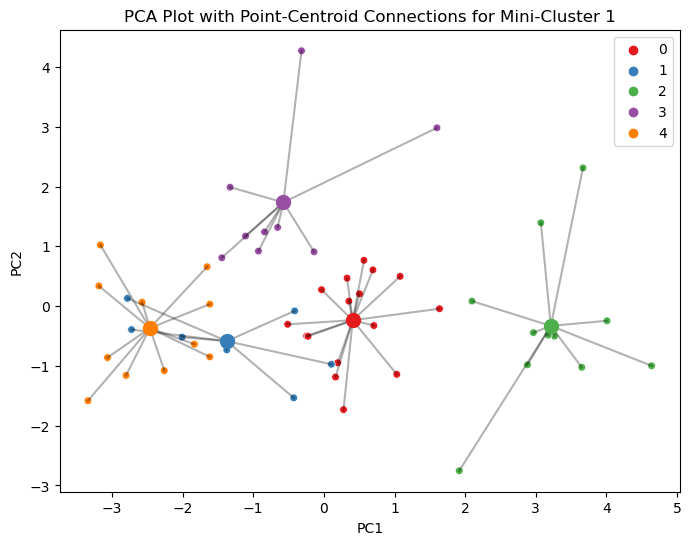

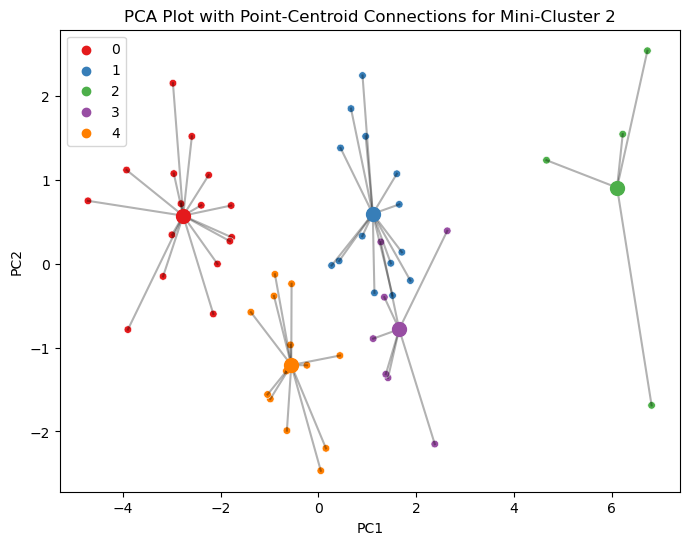

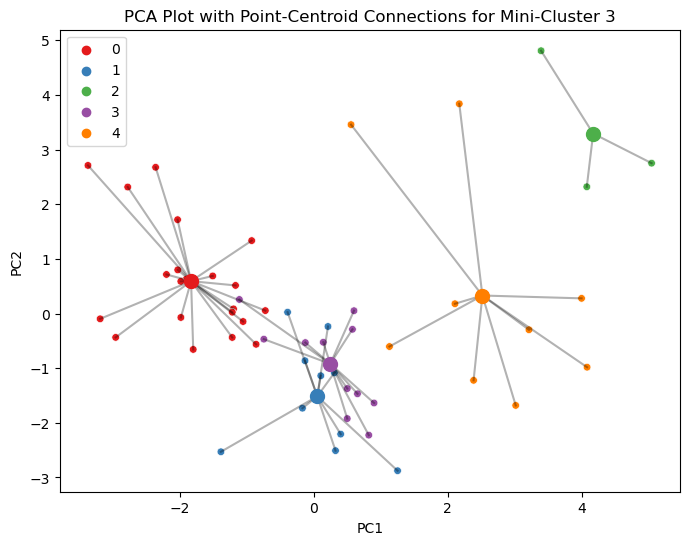

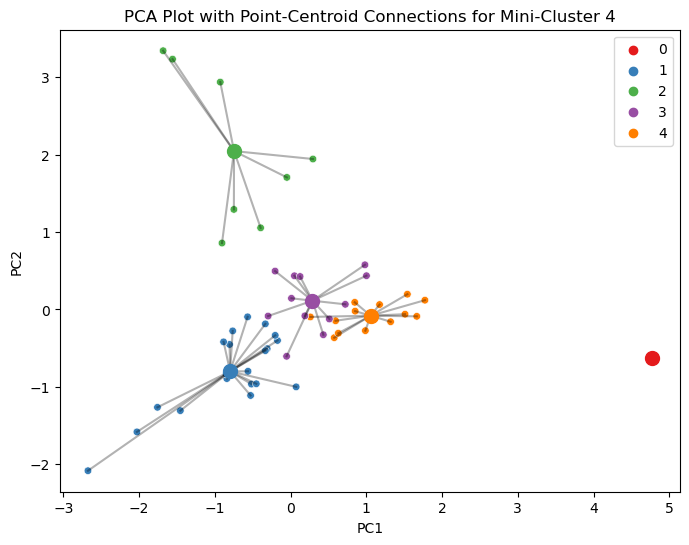

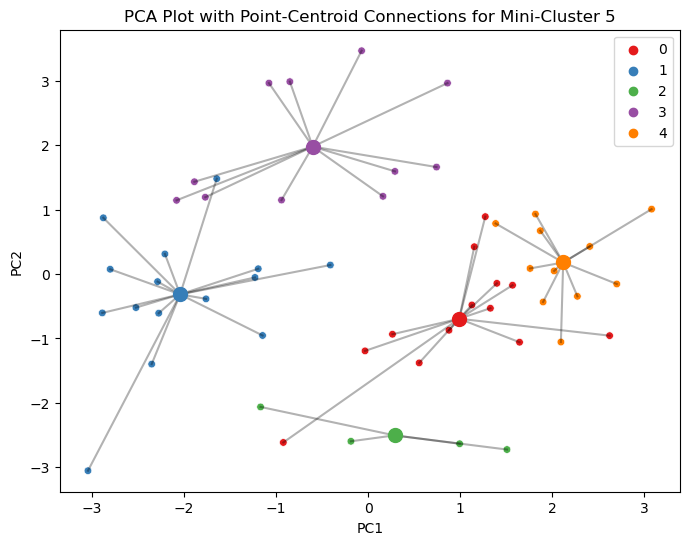

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# List of mini-cluster dataframes
mini_clusters = [df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered]
# Create a list to store PCA models for each mini-cluster
MiniCluster_PCAs = []
# Define a custom color palette for clusters using 'Set1'
custom_palette = sns.color_palette("Set1", n_colors=len(mini_clusters))

# Apply PCA and plot for each mini-cluster
for i, mini_cluster in enumerate(mini_clusters, 1):
    # Extract the feature columns (excluding 'Cluster' column)
    feature_columns = mini_cluster.columns.difference(['Cluster'])

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(mini_cluster[feature_columns])
    # Store PCA model in the list
    MiniCluster_PCAs.append(pca)

    # Create a new dataframe with PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = mini_cluster['Cluster']

    # Calculate centroids
    centroids = df_pca.groupby('Cluster').mean()

    # Plot the PCA results for each mini-cluster with custom size and color palette
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette=custom_palette, s=30)

    # Draw lines from each point to its cluster centroid
    for cluster, centroid in centroids.iterrows():
        points_in_cluster = df_pca[df_pca['Cluster'] == cluster][['PC1', 'PC2']].values
        for point in points_in_cluster:
            plt.plot([point[0], centroid['PC1']], [point[1], centroid['PC2']], 'k-', alpha=0.3)  # Lines from points to centroid
        plt.plot(centroid['PC1'], centroid['PC2'], 'o', color=custom_palette[cluster], markersize=10)

    plt.title(f'PCA Plot with Point-Centroid Connections for Mini-Cluster {i}')
    plt.legend()
    plt.show()


In [ ]:
df_group1_result = df_group1.copy()
df_group1_result['Cluster'] = df_group1_clustered['Cluster']

df_group2_result = df_group2.copy()
df_group2_result['Cluster'] = df_group2_clustered['Cluster']

df_group3_result = df_group3.copy()
df_group3_result['Cluster'] = df_group3_clustered['Cluster']

df_group4_result = df_group4.copy()
df_group4_result['Cluster'] = df_group4_clustered['Cluster']

df_group5_result = df_group5.copy()
df_group5_result['Cluster'] = df_group5_clustered['Cluster']

#to test
print("Combined Dataframe:")
print(df_group1_result.head())

Combined Dataframe:
                           store_name  net_rev_monthly  after_discount  \
0            Sociolla Lippo Mall Puri       2283757349      2622787612   
1               Sociolla Pakuwon Mall       2548571915      2960244908   
2         Sociolla Summarecon Serpong       2211739674      2534646325   
3  Sociolla Lippo Mall Kemang Village       1588809712      1807625526   
4             Sociolla Sunplaza Medan       2627900688      3004533618   

   aov_amount  order_per_shopper  order_count  atu_parameter  unique_shoppers  \
0      307977           1.811144         8516       3.231682             4702   
1      245521           2.499896        12057       2.845650             4823   
2      245065           1.960387        10343       2.915982             5276   
3      298699           1.836722         6052       3.259253             3295   
4      255310           2.449625        11768       3.021159             4804   

   Cluster  
0        2  
1        2  
2        

In [ ]:
!pip install openpyxl
# Display the clustered results for each group
output_file = 'clustered_results_20240229.xlsx'

# Create an Excel writer
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Write each dataframe to a separate sheet
    df_group1_result.to_excel(writer, sheet_name='df_group1_result', index=False)
    df_group2_result.to_excel(writer, sheet_name='df_group2_result', index=False)
    df_group3_result.to_excel(writer, sheet_name='df_group3_result', index=False)
    df_group4_result.to_excel(writer, sheet_name='df_group4_result', index=False)
    df_group5_result.to_excel(writer, sheet_name='df_group5_result', index=False)

-----Notes on Interpreting the Mini-Clusters-----

Interpreting PCA plots involves understanding the principal components (PC1 and PC2) and their relationship with the original features in your dataset. Here are some general guidelines for interpreting PCA plots:

1. Principal Components (PC1 and PC2):

PC1: This is the first principal component, and it represents the direction in the data with the maximum variance. It captures the most significant patterns in the data.
PC2: This is the second principal component, orthogonal (uncorrelated) to PC1, and it represents the second largest source of variance.

2. Variance Explained:

Look at the explained variance ratio for each principal component. This indicates the proportion of total variance in the data that is captured by each component. You can access this information using pca.explained_variance_ratio_.

3. Interpreting Loadings:

Loadings represent the contribution of each original feature to the principal components. Positive and negative loadings indicate the direction of the feature's influence on the component.
The larger the absolute value of the loading, the more the feature contributes to that principal component.

4.Cluster Separation:

Observe how well-separated the clusters are in the PCA plot. If clusters are distinct, it indicates that the original features contribute to a meaningful separation.
If clusters overlap or are close, it might suggest that the features do not provide clear separation along these principal components.

5.Point-Centroid Connections:

The lines connecting each point to its cluster centroid in your plot show the direction and magnitude of the relationship between the point and the centroid.
If a point is close to the centroid, it suggests that the features of that point are well-represented by the principal components.

6.Correlation with Original Features:

If you have access to the loadings of each principal component, you can check which original features contribute most to the direction of each principal component. Positive and negative loadings indicate the direction of influence.


Here's a general interpretation:

Points that are close together on the plot share similar patterns of variation based on the original features.
Distances between points and centroids reflect how well a point is represented by its cluster's centroid in the reduced-dimensional space.

In [ ]:
! pip install xlsxwriter
with pd.ExcelWriter('pca_results_20240929.xlsx', engine='xlsxwriter') as writer:
    # Iterate through mini-clusters
    for i, mini_cluster in enumerate(mini_clusters, 1):
        # Access the previously fitted PCA model
        pca_model = MiniCluster_PCAs[i-1]  # Assuming you stored your PCA models in MiniCluster_PCAs list during the initial clustering

        # Extract the feature columns (excluding 'Cluster' column)
        feature_columns = mini_cluster.columns.difference(['Cluster'])

        # Store loadings in a DataFrame with original column names
        loadings_df = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, pca_model.n_components_ + 1)], index=feature_columns)

        # Print or store loadings for each mini-cluster
        print(f"Loadings for Mini-Cluster {i}:")
        print(loadings_df)

        # Add loadings DataFrame to the dictionary
        loadings_dict[f'MiniCluster_{i}'] = loadings_df

        # Save loadings to Excel file
        loadings_df.to_excel(writer, sheet_name=f'MiniCluster_{i}')

# Access loadings for a specific mini-cluster (e.g., MiniCluster_1)
# print("Loadings for Mini-Cluster 1:")
# print(loadings_dict['MiniCluster_4'])

Loadings for Mini-Cluster 1:
        PC1       PC2
0  0.476899 -0.122130
1  0.477499 -0.117392
2  0.290376  0.623751
3  0.013596 -0.071695
4  0.452555 -0.284470
5  0.267153  0.654275
6  0.428816 -0.260957


NameError: name 'loadings_dict' is not defined

In [ ]:

loadings_dict = {}

# Iterate through mini-clusters
for i, mini_cluster in enumerate(mini_clusters, 1):
    # Access the previously fitted PCA model
    pca_model = MiniCluster_PCAs[i-1]  # Assuming you stored your PCA models in MiniCluster_PCAs list during the initial clustering

    # Extract the feature columns (excluding 'Cluster' column)
    feature_columns = mini_cluster.columns.difference(['Cluster'])

    # Store loadings in a DataFrame with original column names
    loadings_df = pd.DataFrame(pca_model.components_.T, columns=[f'PC{i}' for i in range(1, pca_model.n_components_ + 1)], index=feature_columns)

    # Print or store loadings for each mini-cluster
    print(f"Loadings for Mini-Cluster {i}:")
    print(loadings_df)

    # Add loadings DataFrame to the dictionary
    loadings_dict[f'MiniCluster_{i}'] = loadings_df


# Access loadings for a specific mini-cluster (e.g., MiniCluster_1)
# print("Loadings for Mini-Cluster 1:")
# print(loadings_dict['MiniCluster_1'])


Loadings for Mini-Cluster 1:
        PC1       PC2
0  0.476899 -0.122130
1  0.477499 -0.117392
2  0.290376  0.623751
3  0.013596 -0.071695
4  0.452555 -0.284470
5  0.267153  0.654275
6  0.428816 -0.260957
Loadings for Mini-Cluster 2:
        PC1       PC2
0 -0.332886  0.434817
1 -0.386370  0.115244
2 -0.195338 -0.678125
3  0.290011 -0.473522
4  0.389817 -0.038053
5  0.387655  0.085604
6  0.367329  0.161633
7  0.346639  0.258226
8  0.245602  0.109524
Loadings for Mini-Cluster 3:
        PC1       PC2
0 -0.384257 -0.306047
1  0.394701  0.070717
2  0.192199 -0.033219
3 -0.161524  0.350429
4 -0.402717  0.138814
5  0.324687  0.391201
6  0.373729  0.275157
7  0.084954 -0.561671
8 -0.376719  0.286441
9 -0.277698  0.363165
Loadings for Mini-Cluster 4:
                                            PC1       PC2
area_category_a. Jabodetabek          -0.017332 -0.106867
area_category_b. Java exc Jabodetabek -0.031817  0.120586
area_category_c. Outside Java          0.049149 -0.013719
city_type_Kabu

In [ ]:
output_file = 'pca_result_20240229.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in loadings_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)


7. Final clustering using attributes of membership values in 5 mini-clusters for each data point

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Combine the clustered mini-groups
df_combined = pd.concat([df_group1_clustered, df_group2_clustered, df_group3_clustered, df_group4_clustered, df_group5_clustered])

# Extract the membership values for each mini-group
membership_columns = ['Cluster']

# Extract the features for the final k-means clustering
final_features = df_combined[membership_columns]

# Run the final k-means clustering
final_num_clusters = 5  # or 6
final_kmeans = KMeans(n_clusters=final_num_clusters, random_state=42)
final_clusters = final_kmeans.fit_predict(final_features)

# Add the final cluster column to the combined dataframe
df_combined['FinalCluster'] = final_clusters

# Display the combined dataframe with final cluster assignments
print("Combined Dataframe with Final Cluster Assignments:")
print(df_combined.head())

# Optionally, you can save the combined dataframe with final cluster assignments to an Excel file
df_combined.to_excel('final_cluster_results.xlsx', index=False)


In [ ]:
# Assuming 'transformed_features' is defined somewhere in your code
# Make sure 'transformed_features' has the same number of columns as your original dataset

# Check the number of columns in df and transformed_features
print("Number of columns in df_features:", df_features.shape[1])
print("Number of columns in transformed_features:", transformed_features.shape[1])

# Check if the number of columns matches
if df_features.shape[1] != transformed_features.shape[1]:
    print("Number of columns in df_features and transformed_features do not match. Adjust the datasets.")

else:
    # Visualize the clusters using PCA for dimensionality reduction
    pca = PCA(n_components=5)
    df_pca = pd.DataFrame(pca.fit_transform(transformed_features_check), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

    # Get the loadings of the original variables on each principal component
    loadings = pca.components_

    # Create a DataFrame to display the loadings
    loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_features.columns[:-1])

    # Display the loadings
    print("Loadings of Original Variables on Each Principal Component:")
    print(loadings_df)


In [ ]:
## Assuming 'transformed_features' is defined somewhere in your code
# Make sure 'transformed_features' has the same number of columns as your original dataset

# Check the number of columns in df and transformed_features
print("Number of columns in df_features:", df_features.shape[1])
print("Number of columns in transformed_features:", transformed_features.shape[1])

# Drop the extra column in transformed_features
transformed_features = transformed_features[:, :df_features.shape[1]]

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=5)
df_pca = pd.DataFrame(pca.fit_transform(transformed_features), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Get the loadings of the original variables on each principal component
loadings = pca.components_

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_features.columns)

# Display the loadings
print("Loadings of Original Variables on Each Principal Component:")
print(loadings_df[['PC1', 'PC2']])

# Display the variables ranked by their influence on the first principal component
print("\nVariables ranked by influence on PC1:")
print(loadings_df['PC1'].abs().sort_values(ascending=False))

# Display the variables ranked by their influence on PC2
print("\nVariables ranked by influence on PC2:")
print(loadings_df['PC2'].abs().sort_values(ascending=False))


In [ ]:
# Save the loadings for PC1 and PC2 to a CSV file
loadings_df[['PC1', 'PC2']].to_csv('loadings_pc1_pc2.csv')

In [ ]:
for cluster_num, group in df.groupby('cluster'):
    print(f"Cluster {cluster_num}:\n")
    print(group)
    print("\n" + "="*50 + "\n")


In [ ]:
# this code downloads the results to check the clustering validity
import os
df['cluster'] = kmeans.fit_predict(transformed_features)
unique_clusters = df['cluster'].unique()

# Group by 'cluster' and store each cluster as a separate DataFrame
cluster_results = {cluster_num: group for cluster_num, group in df.groupby('cluster')}
save_directory = 'C:/Users/tiara.santoso/Downloads/Data Exports'

# Save each cluster as a separate CSV file
# for cluster_num in unique_clusters:
#     cluster_df = cluster_results[cluster_num]
#     file_path = os.path.join(save_directory, f'cluster_{cluster_num}_results.csv')
#     cluster_df.to_csv(file_path, index=False)

# Alternatively, concatenate all clusters into a single DataFrame and save as one CSV file
all_cluster_df = pd.concat(list(cluster_results.values()), ignore_index=True)
all_file_path = os.path.join(save_directory, '20240117-all_clusters_results_1.1_without_outliers_clusters2.csv')
all_cluster_df.to_csv(all_file_path, index=False)


In [ ]:
features = ['net_rev_monthly','after_discount','percentage_disc_to_nmv','aov_amount','order_count','quantity_count','unique_shoppers',
            'guest_order','store_size','sales_per_sqm','store_life','cat_skincare','cat_makeup','cat_bath_and_body','cat_haircare','cat_accessories',
            'cat_fragrance','cat_supplement','cat_shaving_grooming','cat_nailcare','cat_sanitary','cat_oralcare','cat_homecare','cat_nursing_feeding','cat_fashion',
            'cat_bedding_bathroom','cat_miscellaneous','area_category','city_type','aovdis<=50k','aovdis50-100k','aovdis100-200k','aovdis200-300k','aovdis>300k',
            'omni_shopper','offline_only','online_order','offline_order','pickup_shopper','pickup_order']

cluster_stats = df.groupby('cluster')[features].describe()
print(cluster_stats)

In [ ]:

cluster_stats = df.groupby('cluster')[features].describe()

save_directory = r'C:\Users\tiara.santoso\Downloads\Data Exports'
cluster_stats.to_csv(os.path.join(save_directory, '20240117-cluster_stats_outliers2.csv'))

In [ ]:
import seaborn as sns

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'Distribution of {feature} within Clusters')
    plt.show()

In [ ]:
import seaborn as sns


In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters
scatter = ax.scatter(df['aov_amount'], df['unique_shoppers'], df['store_size'], c=df['cluster'], cmap='viridis', alpha=0.7)

ax.set_xlabel('AOV Amount')
ax.set_ylabel('Unique Shoppers')
ax.set_zlabel('Store Size')
ax.set_title('K-Means Clustering (5 Clusters) - 3D Visualization')

# Add a legend
legend_labels = np.unique(df['cluster'])
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

plt.show()